# Comparison of Wordrank and Word2Vec

Wordrank is a fresh new approach to the word embeddings, which formulates it as a ranking problem. That is, given a word w, it aims to output an ordered list (c1, c2, · · ·) of context words such that words that co-occur with w appear at the top of the list. This formulation fits naturally to popular word embedding tasks such as word similarity/analogy since instead of the likelihood of each word, we are interested in finding the most relevant words
in a given context.

Gensim is used to train the word2vec models, and analogical reasoning task is used for comparing the models. Word2vec and FastText embeddings are trained using the skipgram architecture here.

# Download and preprocess data

In [1]:
import nltk
from gensim.parsing.preprocessing import strip_punctuation, strip_multiple_whitespaces

# Only the brown corpus is needed in case you don't have it.
nltk.download('brown') 

# Generate brown corpus text file
with open('brown_corp.txt', 'w+') as f:
    for word in nltk.corpus.brown.words():
        f.write('{word} '.format(word=word))
    f.seek(0)
    brown = f.read()

# Preprocess brown corpus
with open('proc_brown_corp.txt', 'w') as f:
    proc_brown = strip_punctuation(brown)
    proc_brown = strip_multiple_whitespaces(proc_brown).lower()
    f.write(proc_brown)

# Set WR_HOME and FT_HOME to respective directory root
WR_HOME = 'wordrank/'
FT_HOME = 'fastText/'

# download the text8 corpus (a 100 MB sample of preprocessed wikipedia text)
import os.path
if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip

[nltk_data] Downloading package brown to /Users/parul/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Train Models
For training the models yourself, you'll need to have Gensim, FastText and Wordrank set up on your machine.

In [2]:
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

from gensim.models import Word2Vec
from gensim.models.wrappers import Wordrank
from gensim.models.word2vec import Text8Corpus

# fasttext params
lr = 0.05
dim = 100
ws = 5
epoch = 5
minCount = 5
neg = 5
loss = 'ns'
t = 1e-4

w2v_params = {
    'alpha': 0.025,
    'size': 100,
    'window': 15,
    'iter': 5,
    'min_count': 5,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': 5
}

wr_params = {
    'size': 100,
    'window': 15,
    'iter': 91,
    'min_count': 5
}

def train_models(corpus_file, output_name):
    # Train using word2vec
    output_file = '{:s}_gs'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining word2vec on {:s} corpus..'.format(corpus_file))
        # Text8Corpus class for reading space-separated words file
        %time gs_model = Word2Vec(Text8Corpus(corpus_file), **w2v_params); gs_model
        locals()['gs_model'].save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved gensim model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))

    # Train using fasttext
    output_file = '{:s}_ft'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('Training fasttext on {:s} corpus..'.format(corpus_file))
        %time !{FT_HOME}fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t}
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    # Train using wordrank
    output_file = '{:s}_wr'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining wordrank on {:s} corpus..'.format(corpus_file))
        %time wr_model = Wordrank.train(WR_HOME, corpus_file, **wr_params); wr_model
        locals()['wr_model'].save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved wordrank model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
     
    # Loading ensemble embeddings
    output_file = '{:s}_wr_ensemble'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nLoading ensemble embeddings (vector combination of word and context embeddings)..')
        %time wr_model = Wordrank.load_wordrank_model(os.path.join(WR_HOME, 'model/wordrank.words'), os.path.join(WR_HOME, 'model/meta/vocab.txt'), os.path.join(WR_HOME, 'model/wordrank.contexts'), sorted_vocab=1, ensemble=1); wr_model
        locals()['wr_model'].save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved wordrank (ensemble) model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
                
train_models(corpus_file='proc_brown_corp.txt', output_name='brown')


Training word2vec on proc_brown_corp.txt corpus..
CPU times: user 1min 7s, sys: 527 ms, total: 1min 8s
Wall time: 46.8 s

Saved gensim model as brown_gs.vec
Training fasttext on proc_brown_corp.txt corpus..
Read 1M words
Number of words:  14042
Number of labels: 0
Progress: 99.6%  words/sec/thread: 58810  lr: 0.000179  loss: 2.348125  eta: 0h0m Progress: 20.1%  words/sec/thread: 30702  lr: 0.039934  loss: 2.296231  eta: 0h0m Progress: 100.0%  words/sec/thread: 58810  lr: 0.000000  loss: 2.348125  eta: 0h0m 
CPU times: user 842 ms, sys: 284 ms, total: 1.13 s
Wall time: 41.3 s

Training wordrank on proc_brown_corp.txt corpus..
CPU times: user 10.8 s, sys: 1.02 s, total: 11.8 s
Wall time: 8h 24min 25s

Saved wordrank model as brown_wr.vec

Loading ensemble embeddings (vector combination of word and context embeddings)..
CPU times: user 8.97 s, sys: 279 ms, total: 9.25 s
Wall time: 13.8 s

Saved wordrank (ensemble) model as brown_wr_ensemble.vec


In [3]:
train_models(corpus_file='text8', output_name='text8')


Training word2vec on text8 corpus..
CPU times: user 24min 21s, sys: 8.64 s, total: 24min 29s
Wall time: 18min 33s

Saved gensim model as text8_gs.vec

Using existing model file text8_ft.vec

Using existing model file text8_wr.vec

Using existing model file text8_wr_ensemble.vec


Here we train wordrank model using ensemble in second case as it is known to give a small performance boost in some cases. So we'll test accuracy for both the cases.

# Comparisons

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def print_accuracy(model, questions_file):
    print('Evaluating...\n')
    acc = model.accuracy(questions_file)

    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))

In [10]:
word_analogies_file = './datasets/questions-words.txt'

print('\nLoading Gensim embeddings')
brown_gs = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_gs.vec')
print('Accuracy for Word2Vec:')
print_accuracy(brown_gs, word_analogies_file)

print('\nLoading FastText embeddings')
brown_ft = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_ft.vec')
print('Accuracy for FastText:')
print_accuracy(brown_ft, word_analogies_file)

print('\nLoading Wordrank embeddings')
brown_wr = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_wr.vec')
print('Accuracy for Wordrank:')
print_accuracy(brown_wr, word_analogies_file)

print('\nLoading Wordrank ensemble embeddings')
brown_wr_ensemble = Word2Vec.load_word2vec_format(MODELS_DIR + 'brown_wr_ensemble.vec')
print('Accuracy for Wordrank:')
print_accuracy(brown_wr_ensemble, word_analogies_file)

2016-12-27 13:58:37,691 : INFO : loading projection weights from models/brown_gs.vec



Loading Gensim embeddings


2016-12-27 13:58:45,351 : INFO : loaded (14042, 100) matrix from models/brown_gs.vec
2016-12-27 13:58:45,418 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Word2Vec:
Evaluating...



2016-12-27 13:58:45,823 : INFO : capital-common-countries: 0.0% (0/90)
2016-12-27 13:58:46,182 : INFO : capital-world: 0.0% (0/53)
2016-12-27 13:58:46,300 : INFO : currency: 0.0% (0/12)
2016-12-27 13:58:48,230 : INFO : city-in-state: 0.9% (4/457)
2016-12-27 13:58:49,250 : INFO : family: 20.0% (48/240)
2016-12-27 13:58:53,225 : INFO : gram1-adjective-to-adverb: 0.1% (1/812)
2016-12-27 13:58:54,105 : INFO : gram2-opposite: 0.0% (0/132)
2016-12-27 13:58:59,197 : INFO : gram3-comparative: 1.8% (19/1056)
2016-12-27 13:59:00,302 : INFO : gram4-superlative: 0.5% (1/210)
2016-12-27 13:59:03,744 : INFO : gram5-present-participle: 2.6% (17/650)
2016-12-27 13:59:05,319 : INFO : gram6-nationality-adjective: 11.4% (34/297)
2016-12-27 13:59:11,041 : INFO : gram7-past-tense: 3.3% (42/1260)
2016-12-27 13:59:14,074 : INFO : gram8-plural: 6.6% (46/702)
2016-12-27 13:59:15,578 : INFO : gram9-plural-verbs: 2.0% (7/342)
2016-12-27 13:59:15,579 : INFO : total: 3.5% (219/6313)
2016-12-27 13:59:15,586 : INFO 


Semantic: 52/852, Accuracy: 6.10%
Syntactic: 167/5461, Accuracy: 3.06%


Loading FastText embeddings


2016-12-27 13:59:21,713 : INFO : loaded (14042, 100) matrix from models/brown_ft.vec
2016-12-27 13:59:21,775 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText:
Evaluating...



2016-12-27 13:59:22,205 : INFO : capital-common-countries: 1.1% (1/90)
2016-12-27 13:59:22,546 : INFO : capital-world: 0.0% (0/53)
2016-12-27 13:59:22,651 : INFO : currency: 0.0% (0/12)
2016-12-27 13:59:24,741 : INFO : city-in-state: 2.4% (11/457)
2016-12-27 13:59:25,821 : INFO : family: 11.7% (28/240)
2016-12-27 13:59:29,840 : INFO : gram1-adjective-to-adverb: 79.9% (649/812)
2016-12-27 13:59:30,628 : INFO : gram2-opposite: 79.5% (105/132)
2016-12-27 13:59:35,972 : INFO : gram3-comparative: 56.3% (595/1056)
2016-12-27 13:59:37,289 : INFO : gram4-superlative: 71.4% (150/210)
2016-12-27 13:59:40,495 : INFO : gram5-present-participle: 65.7% (427/650)
2016-12-27 13:59:41,863 : INFO : gram6-nationality-adjective: 35.0% (104/297)
2016-12-27 13:59:47,878 : INFO : gram7-past-tense: 12.1% (153/1260)
2016-12-27 13:59:51,524 : INFO : gram8-plural: 53.1% (373/702)
2016-12-27 13:59:53,380 : INFO : gram9-plural-verbs: 69.0% (236/342)
2016-12-27 13:59:53,382 : INFO : total: 44.9% (2832/6313)
2016-12


Semantic: 40/852, Accuracy: 4.69%
Syntactic: 2792/5461, Accuracy: 51.13%


Loading Wordrank embeddings


2016-12-27 14:00:00,114 : INFO : loaded (14042, 100) matrix from models/brown_wr.vec
2016-12-27 14:00:00,173 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:
Evaluating...



2016-12-27 14:00:00,438 : INFO : capital-common-countries: 10.0% (9/90)
2016-12-27 14:00:00,694 : INFO : capital-world: 15.1% (8/53)
2016-12-27 14:00:00,762 : INFO : currency: 0.0% (0/12)
2016-12-27 14:00:02,165 : INFO : city-in-state: 8.1% (37/457)
2016-12-27 14:00:02,909 : INFO : family: 23.8% (57/240)
2016-12-27 14:00:05,119 : INFO : gram1-adjective-to-adverb: 0.6% (5/812)
2016-12-27 14:00:05,616 : INFO : gram2-opposite: 0.0% (0/132)
2016-12-27 14:00:09,606 : INFO : gram3-comparative: 2.0% (21/1056)
2016-12-27 14:00:10,392 : INFO : gram4-superlative: 1.0% (2/210)
2016-12-27 14:00:12,894 : INFO : gram5-present-participle: 0.5% (3/650)
2016-12-27 14:00:14,405 : INFO : gram6-nationality-adjective: 10.8% (32/297)
2016-12-27 14:00:18,084 : INFO : gram7-past-tense: 1.6% (20/1260)
2016-12-27 14:00:20,194 : INFO : gram8-plural: 8.3% (58/702)
2016-12-27 14:00:21,221 : INFO : gram9-plural-verbs: 0.3% (1/342)
2016-12-27 14:00:21,222 : INFO : total: 4.0% (253/6313)
2016-12-27 14:00:21,229 : INF


Semantic: 111/852, Accuracy: 13.03%
Syntactic: 142/5461, Accuracy: 2.60%


Loading Wordrank ensemble embeddings


2016-12-27 14:00:25,328 : INFO : loaded (14042, 100) matrix from models/brown_wr_ensemble.vec
2016-12-27 14:00:25,413 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:
Evaluating...



2016-12-27 14:00:25,898 : INFO : capital-common-countries: 14.4% (13/90)
2016-12-27 14:00:26,340 : INFO : capital-world: 18.9% (10/53)
2016-12-27 14:00:26,469 : INFO : currency: 0.0% (0/12)
2016-12-27 14:00:28,738 : INFO : city-in-state: 8.3% (38/457)
2016-12-27 14:00:29,890 : INFO : family: 28.8% (69/240)
2016-12-27 14:00:33,588 : INFO : gram1-adjective-to-adverb: 0.6% (5/812)
2016-12-27 14:00:34,111 : INFO : gram2-opposite: 0.0% (0/132)
2016-12-27 14:00:38,860 : INFO : gram3-comparative: 3.4% (36/1056)
2016-12-27 14:00:40,451 : INFO : gram4-superlative: 0.0% (0/210)
2016-12-27 14:00:44,070 : INFO : gram5-present-participle: 1.7% (11/650)
2016-12-27 14:00:45,958 : INFO : gram6-nationality-adjective: 16.8% (50/297)
2016-12-27 14:00:52,447 : INFO : gram7-past-tense: 3.8% (48/1260)
2016-12-27 14:00:56,598 : INFO : gram8-plural: 11.1% (78/702)
2016-12-27 14:00:58,343 : INFO : gram9-plural-verbs: 0.9% (3/342)
2016-12-27 14:00:58,344 : INFO : total: 5.7% (361/6313)



Semantic: 130/852, Accuracy: 15.26%
Syntactic: 231/5461, Accuracy: 4.23%



As evident from the above outputs, wordrank performs better in semantic analogies, whereas, fasttext performs significantly better in syntactic analogies. Also ensemble embeddings gives a small performance boost in wordrank's case.

Wordrank's effectiveness in Semantic analogies is possibly due to it's focused attention on getting most relevant words right at the top using the ranking approach.
And as fasttext is designed to incorporate morphological information about words, it results in it's performance boost in syntactic analogies, as most of the syntactic analogies are morphology based.

Now lets evaluate on a larger corpus, text8, and see how it effects the performance of different embedding models.   

In [13]:
print('Loading Gensim embeddings')
text8_gs = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_gs.vec')
print('Accuracy for word2vec:')
print_accuracy(text8_gs, word_analogies_file)

print('Loading FastText embeddings')
text8_ft = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_ft.vec')
print('Accuracy for FastText (with n-grams):')
print_accuracy(text8_ft, word_analogies_file)

print('\nLoading Wordrank embeddings')
text8_wr = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_wr.vec')
print('Accuracy for Wordrank:')
print_accuracy(text8_wr, word_analogies_file)

print('\nLoading Wordrank ensemble embeddings')
text8_wr_ensemble = Word2Vec.load_word2vec_format(MODELS_DIR + 'text8_wr_ensemble.vec')
print('Accuracy for Wordrank:')
print_accuracy(text8_wr_ensemble, word_analogies_file)

2016-12-27 18:10:28,984 : INFO : loading projection weights from models/text8_gs.vec


Loading Gensim embeddings


2016-12-27 18:10:36,842 : INFO : loaded (71290, 100) matrix from models/text8_gs.vec
2016-12-27 18:10:36,908 : INFO : precomputing L2-norms of word weight vectors


Accuracy for word2vec:
Evaluating...



2016-12-27 18:10:38,821 : INFO : capital-common-countries: 68.6% (347/506)
2016-12-27 18:10:44,002 : INFO : capital-world: 52.3% (760/1452)
2016-12-27 18:10:44,976 : INFO : currency: 19.8% (53/268)
2016-12-27 18:10:50,552 : INFO : city-in-state: 24.8% (389/1571)
2016-12-27 18:10:51,692 : INFO : family: 47.7% (146/306)
2016-12-27 18:10:55,175 : INFO : gram1-adjective-to-adverb: 18.0% (136/756)
2016-12-27 18:10:56,535 : INFO : gram2-opposite: 13.4% (41/306)
2016-12-27 18:11:01,901 : INFO : gram3-comparative: 37.8% (476/1260)
2016-12-27 18:11:03,798 : INFO : gram4-superlative: 22.3% (113/506)
2016-12-27 18:11:07,566 : INFO : gram5-present-participle: 22.9% (227/992)
2016-12-27 18:11:12,830 : INFO : gram6-nationality-adjective: 86.7% (1188/1371)
2016-12-27 18:11:18,266 : INFO : gram7-past-tense: 27.0% (359/1332)
2016-12-27 18:11:21,913 : INFO : gram8-plural: 54.4% (540/992)
2016-12-27 18:11:24,023 : INFO : gram9-plural-verbs: 25.2% (164/650)
2016-12-27 18:11:24,025 : INFO : total: 40.3% (4


Semantic: 1695/4103, Accuracy: 41.31%
Syntactic: 3244/8165, Accuracy: 39.73%

Loading FastText embeddings


2016-12-27 18:11:31,749 : INFO : loaded (71290, 100) matrix from models/text8_ft.vec
2016-12-27 18:11:31,977 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2016-12-27 18:11:33,667 : INFO : capital-common-countries: 62.5% (316/506)
2016-12-27 18:11:38,357 : INFO : capital-world: 43.0% (625/1452)
2016-12-27 18:11:39,239 : INFO : currency: 12.7% (34/268)
2016-12-27 18:11:44,264 : INFO : city-in-state: 18.3% (287/1571)
2016-12-27 18:11:45,264 : INFO : family: 43.5% (133/306)
2016-12-27 18:11:47,685 : INFO : gram1-adjective-to-adverb: 73.7% (557/756)
2016-12-27 18:11:48,692 : INFO : gram2-opposite: 53.9% (165/306)
2016-12-27 18:11:52,716 : INFO : gram3-comparative: 64.8% (816/1260)
2016-12-27 18:11:54,355 : INFO : gram4-superlative: 53.4% (270/506)
2016-12-27 18:11:57,536 : INFO : gram5-present-participle: 54.4% (540/992)
2016-12-27 18:12:01,932 : INFO : gram6-nationality-adjective: 93.9% (1288/1371)
2016-12-27 18:12:06,220 : INFO : gram7-past-tense: 35.6% (474/1332)
2016-12-27 18:12:09,390 : INFO : gram8-plural: 90.1% (894/992)
2016-12-27 18:12:11,479 : INFO : gram9-plural-verbs: 59.4% (386/650)
2016-12-27 18:12:11,481 : INFO : total: 55.3% (


Semantic: 1395/4103, Accuracy: 34.00%
Syntactic: 5390/8165, Accuracy: 66.01%


Loading Wordrank embeddings


2016-12-27 18:12:18,908 : INFO : loaded (71290, 100) matrix from models/text8_wr.vec
2016-12-27 18:12:18,987 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:
Evaluating...



2016-12-27 18:12:20,718 : INFO : capital-common-countries: 84.6% (428/506)
2016-12-27 18:12:25,378 : INFO : capital-world: 70.0% (1016/1452)
2016-12-27 18:12:26,259 : INFO : currency: 19.0% (51/268)
2016-12-27 18:12:31,261 : INFO : city-in-state: 36.0% (565/1571)
2016-12-27 18:12:32,263 : INFO : family: 57.8% (177/306)
2016-12-27 18:12:34,677 : INFO : gram1-adjective-to-adverb: 15.3% (116/756)
2016-12-27 18:12:35,679 : INFO : gram2-opposite: 15.4% (47/306)
2016-12-27 18:12:39,683 : INFO : gram3-comparative: 33.8% (426/1260)
2016-12-27 18:12:41,314 : INFO : gram4-superlative: 21.1% (107/506)
2016-12-27 18:12:44,488 : INFO : gram5-present-participle: 23.8% (236/992)
2016-12-27 18:12:48,855 : INFO : gram6-nationality-adjective: 90.2% (1237/1371)
2016-12-27 18:12:53,089 : INFO : gram7-past-tense: 26.4% (351/1332)
2016-12-27 18:12:56,261 : INFO : gram8-plural: 60.9% (604/992)
2016-12-27 18:12:58,352 : INFO : gram9-plural-verbs: 19.7% (128/650)
2016-12-27 18:12:58,354 : INFO : total: 44.7% (


Semantic: 2237/4103, Accuracy: 54.52%
Syntactic: 3252/8165, Accuracy: 39.83%


Loading Wordrank ensemble embeddings


2016-12-27 18:13:05,876 : INFO : loaded (71290, 100) matrix from models/text8_wr_ensemble.vec
2016-12-27 18:13:05,973 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:
Evaluating...



2016-12-27 18:13:07,668 : INFO : capital-common-countries: 67.0% (339/506)
2016-12-27 18:13:12,303 : INFO : capital-world: 59.0% (856/1452)
2016-12-27 18:13:13,193 : INFO : currency: 17.2% (46/268)
2016-12-27 18:13:18,175 : INFO : city-in-state: 33.0% (519/1571)
2016-12-27 18:13:19,222 : INFO : family: 32.0% (98/306)
2016-12-27 18:13:21,637 : INFO : gram1-adjective-to-adverb: 10.3% (78/756)
2016-12-27 18:13:22,645 : INFO : gram2-opposite: 10.5% (32/306)
2016-12-27 18:13:26,626 : INFO : gram3-comparative: 24.4% (308/1260)
2016-12-27 18:13:28,253 : INFO : gram4-superlative: 11.5% (58/506)
2016-12-27 18:13:31,412 : INFO : gram5-present-participle: 11.7% (116/992)
2016-12-27 18:13:35,744 : INFO : gram6-nationality-adjective: 71.8% (985/1371)
2016-12-27 18:13:39,971 : INFO : gram7-past-tense: 17.0% (226/1332)
2016-12-27 18:13:43,150 : INFO : gram8-plural: 47.8% (474/992)
2016-12-27 18:13:45,243 : INFO : gram9-plural-verbs: 11.7% (76/650)
2016-12-27 18:13:45,245 : INFO : total: 34.3% (4211/1


Semantic: 1858/4103, Accuracy: 45.28%
Syntactic: 2353/8165, Accuracy: 28.82%



With a larger corpus, we observe similar pattern in the accuracies. Here also, wordrank dominates the semantic analogies and fasttext syntactic ones.
Though we observe a little performance decrease in Wordrank in case of ensemble embeddings here, so it's good to always try both the cases for evaluations.

Now, following graph shows the word frequency effect on analogy task accuracy. For each analogy, the
mean frequency of the four words involved is computed, and then bucketed with other analogies having similar mean frequencies.

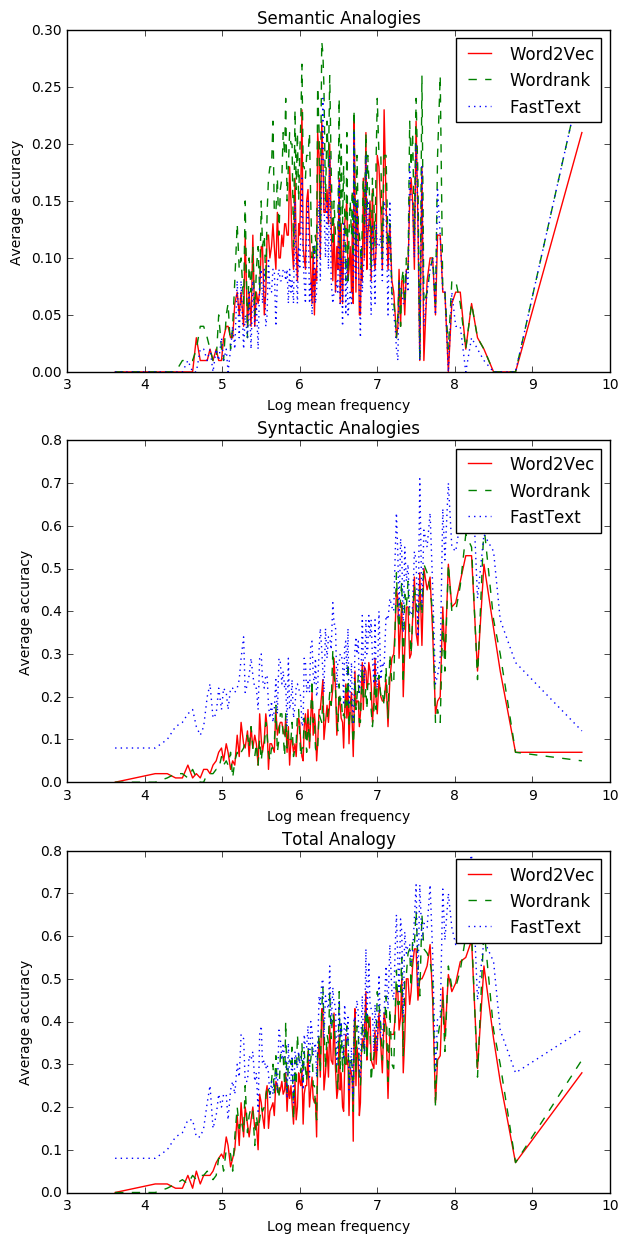

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import copy
import numpy as np
from gensim.models import Word2Vec
import os

os.chdir('models')
word_analogies_file = '../datasets/questions-words.txt'
def calc_parm(model, vocab):
    freq = {}
    with open(vocab, 'r') as r:
        for line in r:
            key, val = line.split()
            freq[key] = val
    mean_freq = {}
    with open(word_analogies_file, 'r') as r:
        for i, line in enumerate(r):
            if ':' not in line:
                analogy = tuple(line.split())
            else:
                continue
            try:
                mfreq = sum([int(freq[x.lower()]) for x in analogy])/4
                mean_freq['a%d'%i] = [analogy, mfreq]
            except KeyError:
                continue

    model = Word2Vec.load_word2vec_format(model)
    acc = model.accuracy(word_analogies_file)
    sem_correct = [acc[i]['correct'] for i in range(5)]
    syn_correct = [acc[i]['correct'] for i in range(5, len(acc)-1)]
    tot_correct = [acc[i]['correct'] for i in range(len(acc)-1)]

    sem_x, sem_y = calc_axis(sem_correct, mean_freq)
    syn_x, syn_y = calc_axis(syn_correct, mean_freq)
    total_x, total_y = calc_axis(tot_correct, mean_freq)
    return ((sem_x, sem_y), (syn_x, syn_y), (total_x, total_y))

def calc_axis(correct, mean_freq):
    total_correct = []
    for i in range(len(correct)):
        for analogy in correct[i]:
            total_correct.append(analogy)

    dup_mean_freq = copy.deepcopy(mean_freq)
    for key, value in dup_mean_freq.iteritems():
        value[0] = tuple(x.upper() for x in value[0])
        if value[0] in total_correct:
            dup_mean_freq[key].append(1)
        else:
            dup_mean_freq[key].append(0)

    x = []
    y = []
    dup_mean_freq = sorted(dup_mean_freq.items(), key=lambda x: x[1][1])
    for centre_p in xrange(50, len(dup_mean_freq), 100):
        bucket = dup_mean_freq[centre_p-50:centre_p+50]
        b_acc = 0
        for analogy in bucket:
            if analogy[1][2]==1:
                b_acc+=1
        y.append(b_acc/100)
        x.append(np.log(dup_mean_freq[centre_p][1][1]))
    return x, y


plot_data0 = calc_parm('text8_gs.vec', 'text8.vocab')
plot_data1 = calc_parm('text8_wr.vec', 'text8.vocab')
plot_data2 = calc_parm('text8_ft.vec', 'text8.vocab')

fig = plt.figure(figsize=(7,15))

ax = fig.add_subplot('311')
ax.plot(plot_data0[0][0], plot_data0[0][1], 'r-', label='Word2Vec')
ax.plot(plot_data1[0][0], plot_data1[0][1], 'g--', label='Wordrank')
ax.plot(plot_data2[0][0], plot_data2[0][1], 'b:', label='FastText')
ax.set_ylabel('Average accuracy')
ax.set_xlabel('Log mean frequency')
ax.set_title('Semantic Analogies')
ax.legend()

ax = fig.add_subplot('312')
ax.plot(plot_data0[1][0], plot_data0[1][1], 'r-', label='Word2Vec')
ax.plot(plot_data1[1][0], plot_data1[1][1], 'g--', label='Wordrank')
ax.plot(plot_data2[1][0], plot_data2[1][1], 'b:', label='FastText')
ax.set_ylabel('Average accuracy')
ax.set_xlabel('Log mean frequency')
ax.set_title('Syntactic Analogies')
ax.legend()

ax = fig.add_subplot('313')
ax.plot(plot_data0[2][0], plot_data0[2][1], 'r-', label='Word2Vec')
ax.plot(plot_data1[2][0], plot_data1[2][1], 'g--', label='Wordrank')
ax.plot(plot_data2[2][0], plot_data2[2][1], 'b:', label='FastText')
ax.set_ylabel('Average accuracy')
ax.set_xlabel('Log mean frequency')
ax.set_title('Total Analogy')
ax.legend()

plt.show()

# Conclusions





Note: Wordrank can sometimes produce Nan values while model evaluation, when the embedding vector values get too diverged at some iterations, but it dumps embedding vectors after every few iterations, so you could just load embeddings from a different iteration’s text file.